## Authentication and Client Creation for CDF

Here we'll create the cognite client using Client credentials. We need to supply the tenant_id, client_id and client secret along with cluster name and project name to create the cognite client. Once this client is created, this will be the main way to communicate with the Cognite Data Fusion.

Import and create a client to communicate with the cognite data platform (CDF)

In [1]:
#from cognite.client import CogniteClient
from cognite.experimental import CogniteClient

In [2]:
import os
from getpass import getpass
from pathlib import Path
from dotenv import load_dotenv
# Contact Project Administrator to get these
TENANT_ID="48d5043c-cf70-4c49-881c-c638f5796997"
CLIENT_ID="fab52bb5-9de2-4f9e-aefa-712da4b5fe00"
CDF_CLUSTER="westeurope-1"
COGNITE_PROJECT="ds-basics"

SCOPES = [f"https://{CDF_CLUSTER}.cognitedata.com/.default"]

# Obtain the Environment Variables from .env file
dotenv_path = Path("../.env")
load_dotenv(dotenv_path=dotenv_path)
CLIENT_SECRET = os.getenv("CLIENT_SECRET") 
#CLIENT_SECRET = getpass("Enter the Client Secret: ") # To pass secret interactively

TOKEN_URL = f"https://login.microsoftonline.com/{TENANT_ID}/oauth2/v2.0/token"

client = CogniteClient(
    token_url=TOKEN_URL,
    token_client_id=CLIENT_ID,
    token_client_secret=CLIENT_SECRET,
    token_scopes=SCOPES,
    project=COGNITE_PROJECT,
    base_url=f"https://{CDF_CLUSTER}.cognitedata.com",
    client_name="cdf_client",
    debug=False,
)

This is just one of the ways to create the client, there are many other ways e.g. Interactive login, Device code etc

Guide for authentication and creating the client is available here https://github.com/cognitedata/python-oidc-authentication

## Machine Learning to Forecast the thermal resistance

Along with the Physics calculations, if we need to predict the values of thermal resistance for future timesteps, based on trend or other factors, we can quickly build a model which will forecast the thermal resistance, based on recent history and it can be used to monitor the Performance of the Heat exchanger and using predictions, we can detect any upcoming issues or problems in the system.

First install the library we'll use for forecasting

In [4]:
%pip install -q Prophet

Note: you may need to restart the kernel to use updated packages.


Now, let's format the data suitable for Prophet functions

In [17]:
df2 = df.copy()[['TR']].reset_index()
df2 = df2.rename(columns={'index':"ds",'TR':"y"})

df2.head()

,ds,y
0,2022-05-17 14:00:00,0.001315
1,2022-05-17 15:00:00,0.001339
2,2022-05-17 16:00:00,0.001307
3,2022-05-17 17:00:00,0.001301
4,2022-05-17 18:00:00,0.001294


In [18]:
df.shape

(22, 7)

In [19]:
from prophet import Prophet

/home/cram/dev/learn-cognite-functions/.venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [20]:
m = Prophet()
m.fit(df2)

15:03:13 - cmdstanpy - INFO - Chain [1] start processing
15:03:13 - cmdstanpy - INFO - Chain [1] done processing


### Forecast for next 15 days

Let's add 10% increase from the historical mean as the threshold for monitoring

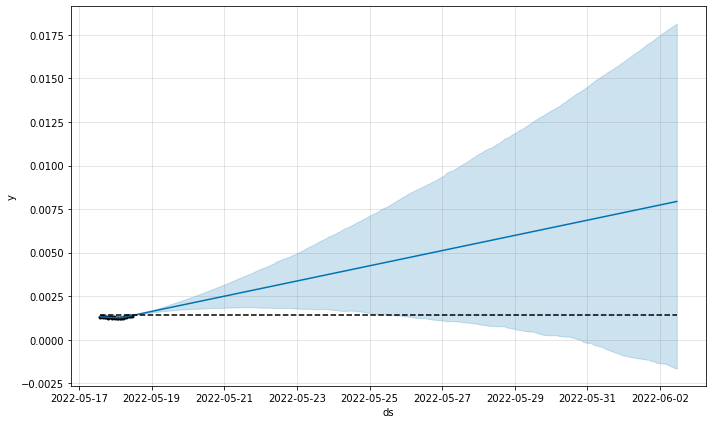

In [23]:
future = m.make_future_dataframe(periods=24*15, freq='H')
future['cap'] = 1.1*df['TR'].mean() #
fcst = m.predict(future)
fig = m.plot(fcst)

It shows that as per current trend based on last few weeks, data, it will cross the threshold very soon. This information can be utilized by the maintenance department or the operations.

Next, we can create the cognite function to run this model daily and save the forecasts in CDF for monitoring purposes.

## Running ML predictions with cognite functions

Add the below code the the handler.py file. Additionally, we need to create a requirements.txt file to add the Prophet library as dependency to be installed.

In [39]:
from cognite.client.data_classes import TimeSeries
from math import log
import datetime
from datetime import timedelta
from prophet import Prophet

def thermal_resistance(x):
    '''Function to calculate Thermal Resistance'''
    # Some constants like Correction factor, Area and Cp values
    F = 0.8
    A = 1.0
    Cp_hot = 2.4
    # Calculate the cross temperature differences
    x['dT1'] = x['T_hot_IN'] - x['T_cold_OUT']
    x['dT2'] = x['T_hot_OUT'] - x['T_cold_IN']
    # Calculate the numerator and denominator for the thermal resistance calculation
    temp1 = A*F*(x['dT1']-x['dT2'])/log(x['dT1']/x['dT2'])
    temp2 = x['Flow_hot']*Cp_hot*(x['T_hot_IN']-x['T_hot_OUT'])
    tr = temp1/temp2
    return tr

def thermal_resistance_forecast(df):
    '''Function to forecast the Thermal Resistance'''
    df2 = df.copy()[['TR']].reset_index()
    df2 = df2.rename(columns={'index':"ds",'TR':"y"})
    m = Prophet()
    m.fit(df2)
    future = m.make_future_dataframe(periods=24*15, freq='H')
    future['cap'] = 1.1*df['TR'].mean() #
    fcst = m.predict(future)
    fcst_df = fcst[['ds','yhat']].set_index('ds')
    fcst_df.columns = ['TR']
    return fcst_df

def create_and_save_time_series_data(client,data,ts_external_id):
  '''Function to create the time series and save the data'''
  asset_id = 7640884189698369 # 23-HA-9114 Asset
  cdf_ts = client.time_series.retrieve(external_id=ts_external_id)
  if cdf_ts is None:
    ts = TimeSeries(external_id=ts_external_id,name=ts_external_id, asset_id = asset_id, unit = 'm2K/W')
    client.time_series.create(ts)
    print("Created time series")
  else:
    print("Existing Time Series")
  dps = []
  for index, r in data.iterrows():
      dps= dps+[{"timestamp": r.name, "value": r['TR']}]
  try:
      client.datapoints.insert(datapoints = dps,external_id = ts_external_id)
  except:
      pass


def handle(client,data=None, secrets=None, function_call_info=None):
    """Handler Function to be Run/Deployed
    Args:
        client : Cognite Client (not needed, it's availble to it, when deployed)
        data : data needed by function
        secrets : Any secrets it needs
        function_call_info : any other information about function

    Returns:
        response : response or result from the function 
    """
    ts_exids = ['pi:163657','pi:163658','pi:160887','pi:191092','pi:163374','pi:160184']
    column_names = ["T_cold_IN","T_cold_OUT","T_hot_IN","T_hot_OUT","Flow_cold","Flow_hot"]
    # Retrieve the data
    start_date = datetime.datetime(2018, 8, 1)
    end_date = start_date + timedelta(days=30)
    df = client.datapoints.retrieve_dataframe(external_id=ts_exids,
                                                        aggregates=['average'],
                                                        granularity='1h',
                                                        start=start_date,
                                                        end=end_date,
                                                        include_aggregate_name=False
                                                        )
    df.fillna(method="ffill", inplace=True)
    df.columns = column_names
    # Calculate the Thermal resistance
    df['TR'] = df.apply(lambda x:thermal_resistance(x),axis=1)
    # Forecast the Thermal resistance
    fcst_df = thermal_resistance_forecast(df)
    # Save the Results as time series
    create_and_save_time_series_data(client,df[['TR']],"hx_thermal_resistance")
    create_and_save_time_series_data(client,fcst_df[['TR']],"hx_thermal_resistance_forecast")
    # Return the result as json
    result = df[['TR']].to_json()
    return result

We can create a new folder and save the updated handler.py & requirements.txt file there.

In [ ]:
# ! mkdir ../hx-thermal-resistance-forecast

In [40]:
function = client.functions.create(
    name="Thermal Performance Forecasting Function",
    external_id="thermal-perf-forecast",
    folder="../hx-thermal-resistance-forecast/",
    description="Function to Calculate & Forecast Thermal Performance of Discharge Coolers",
    owner="Choukha Ram"
    )
# Note : if this cell is giving you errors :
# Just restart the notebook, create the cognite client and run this cell again.

## Cleanup

You can delete the created/deployed function using Code or UI. This will also delete the schedules along with them.

In [ ]:
client.functions.delete(id=function.id)